In [1]:
import numpy as np
import pandas as pd
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set(font_scale = 1.6)

---
# Реализуем решающее дерево как в sklearn

Вспомним, как именно происходит построение решающего дерева. Для построения дерева в каждой нелистовой вершине происходит разбиение подвыборки на две части по некоторому признаку $x_j$. Этот признак и порог $t$, по которому будет происходить разбиение, мы хотим брать не произвольно, а основываясь на соображениях оптимальности.  Для этого нам необходимо задать некоторый фукционал качества, который будем оптимизировать при построении разбиения

Обозначим через $X_m$ — множество объектов, попавших в вершину $m$, разбиваемую на данном шаге, а через $X_l$ и $X_r$ — объекты, попадающие в левое и правое поддерево соответственно при заданном правиле $I\{x_j < t\}$. Пусть также $H$ — используемый критерий информативности (impurity criterion).

При разбиении вершины мы минимизируем так называемое `impurity`:

$$Q(X_m, j, t) = \frac{|X_l|}{|X|}H(X_l) + \frac{|X_r|}{|X|}H(X_r).$$

Общая идея для всех критериев информативности и что они пытаются минимизировать:

**Ответ.** Чем меньше разнообразие целевой переменной, тем меньше должно быть значение критерия информативности — и, соответственно, мы будем пытаться минимизировать его значение. Тогда функционал качества $Q(X_m, j, t)$ будет показывать качество разбиения по предикату $\{x^j < t\}$, то есть однородность полученных вершин. Его мы пытаемся минимизировать.


In [15]:
# Код функций, реализующих критерии разбиения. 

def mean_square_criterion(y):
    ''' Критерий для квадратичной функции потерь. '''
    
    return np.mean((y - np.mean(y))**2)


def mean_abs_criterion(y):
    ''' Критерий для абсолютной функции потерь. '''
    
    return np.mean(np.absolute(y - np.median(y)))


def get_probs_by_y(y):
    ''' Возвращает вектор частот для каждого класса выборки. '''
    
    _, counts = np.unique(y, return_counts=True)
    return counts / np.sum(counts)


def gini_criterion(y):
    ''' Критерий Джини. '''
    
    probs = get_probs_by_y(y)
    return np.sum(probs * (1 - probs))


def entropy_criterion(y):
    ''' Энтропийный критерий. '''
    
    probs = get_probs_by_y(y)
    return -np.sum(probs * np.log(probs))

Немного тестов

In [3]:
assert np.allclose(get_probs_by_y([1, 1, 2, 2, 7]), 
                   np.array([0.4, 0.4, 0.2]))
assert np.allclose(get_probs_by_y([1]), np.array([1]))

Еще немного тестов для критериев разбиения

In [4]:
assert np.allclose(entropy_criterion([25]), 0)
assert np.allclose(gini_criterion([25]), 0)
assert np.allclose(mean_square_criterion([10, 10, 10]), 0)
assert np.allclose(mean_abs_criterion([10, 10, 10]), 0)

**Реализация класса решающего дерева.**

Используются следующие классы:

**Класс 1**. `BaseDecisionTree` — класс для решающего дерева, в котором реализовано построение дерева. Все вершины дерева хранятся в списке `self.nodes`, при этом вершина с номером 0 — корень.


1) `__init__` — инициализация дерева. Здесь сохраняются гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_split` и инициализируется список вершин, состоящий только из одной вершины — корневой,

2) `build_` — рекурсивная функция построения дерева. В ней при посещении каждой вершины дерева проверяются условия, стоит ли продолжать разбивать эту вершину. Если да, то перебираются все возможные признаки и пороговые значения и выбирается та пара (признак, значение), которой соответствует наименьшее значение функционала,

3) `fit` — функция обучения дерева, принимающая на вход обучающую выборку. В этой функции происходит предподсчёт всех возможных пороговых значений для каждого из признаков, а затем вызывается функция `build_`.

**Класс 2**. `Node` — класс вершины дерева. Внутри вершины, помимо раздяляющего признака и порога хранятся `self.left_son`, `self.right_son` — номера дочерних вершин, а также `self.left_prob` и `self.right_prob` — вероятности попадания элемента в каждую из них (это потребуется при обработке данных с пропусками). При этом в листовых вершиных хранятся также `self.y_values` — значения соответствующих элементов выборки, попавших в вершину.

1) `__init__` — инициализация вершины. Принимает в качестве аргументов разделяющий признак и пороговое значение и сохраняет их.

**Класс 3**. `DecisionTreeRegressor` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи регрессии.

1) `predict_instance` — получение предсказания для одного элемента выборки. Выполняется посредством спуска по решающему дереву до листовой вершины,

2) `predict` — получение предсказаний для всех элементов выборки.


**Класс 4**. `DecisionTreeClassifier` — наследник класса `BaseDecisionTree`, в котором реализованы функции для предсказаний при решении задачи классификации.

1) `predict_proba_instance` — предсказание распределение вероятностей по классам для одного элемента выборки, 

2) `predict_proba` — предсказание распределение вероятностей по классам для всех элементов выборки,

3) `predict` — предсказание меток классов для всех элементов выборки.

**Структура решающего дерева**

<img src="https://i.ibb.co/N2W2Zd4/decision-tree-scheme.png"/>

In [5]:
def get_not_nans(arr):
    '''
    функция которая создаёт и возвращает новый массив 
    из всех элементов переданного массива, не являющихся None.
    '''
    
    return arr.copy()[~np.isnan(arr)]


class Node(object):
    def __init__(self, split_feature = None, split_threshold = None):
        '''
        инициализация вершины решающего дерева.
        
        1) split_feature — номер разделяющего признака
        2) split_threshold — пороговое значение
        '''
        
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        # По умолчанию считаем, что у вершины нет дочерних вершин.
        self.left_son, self.right_son = None, None
        # Вероятности попадания в каждую из дочерних вершин нужно поддерживать 
        # для корректной обработки данных с пропусками
        self.left_prob, self.right_prob = 0, 0
        # Массив значений y. Определён только для листовых вершин дерева
        self.y_values = None
        

class BaseDecisionTree(BaseEstimator):
    '''
    реализация всех основных функций для работы
    с решающим деревом.
    
    наследование от класса BaseEstimator нужно для того, чтобы 
    в дальнейшем данный   класс можно было использовать в 
    различных функциях библиотеки sklearn, например, в функциях 
    для кросс-валидации
    '''
    
    def __init__(self,
                 criterion,
                 max_depth=np.inf,
                 min_samples_split=2):
        '''
        1) criterion — критерий информативности, 
        2) max_depth — максимальная глубина дерева,
        3) min_samples_split — минимальное количество элементов 
        обучающей выборки,  которое должно попасть в вершину, 
        чтобы потом происходило разбиение этой вершины.
        '''
        
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        # Список всех вершин дерева. В самом начале 
        # работы алгоритма есть только одна 
        # вершина — корень.
        self.nodes = [Node()]
        # Количество классов. Актуально только 
        # при решении задачи классификации.
        self.class_count = 1
        # Сюда нужно будет записать все значения 
        # для каждого из признаков датасета.
        self.feature_values = None
    
    def build_(self, v, X, y, depth = 0):
        '''
        рекурсивная функция построения дерева
        
        1) v — номер рассматриваемой вершины
        2) X, y — обучающая выборка, попавшая в текущую вершину
        3) depth — глубина вершины с номером v
        '''
        
        reached_max_depth = depth == self.max_depth
        not_enough_split = len(y) < self.min_samples_split
        is_homogenous = len(np.unique(y)) == 1
        if reached_max_depth or not_enough_split or is_homogenous:
            # Еcли строим дерево для классификации, то 
            # сохраняем метки классов всех элементов выборки,
            # попавших в вершину.
            if callable(getattr(self, "set_class_count", None)):
                self.nodes[v].y_values = y.copy()
            # Для регрессии сразу вычислим среднее всех 
            # элементов вершины.
            else:
                self.nodes[v].y_values = np.mean(y)
            return
        
        best_criterion_value = np.inf
        best_feature, best_threshold = 0, 0
        sample_size, feature_count = X.shape
        
        # переберём все возможные признаки и значения порогов,
        # найдём оптимальный признак и значение порога 
        # и запишем их в best_feature, best_threshold
        for feature_id in range(feature_count):
            for threshold in self.feature_values[feature_id]:
                # делим вершину по рассматриваемому признаку 
                # и пороговому значению
                y_l = y[np.nan_to_num(
                    X[:, feature_id], threshold
                ) < threshold]
                y_r = y[np.nan_to_num(
                    X[:, feature_id], threshold - 1
                ) >= threshold]
                if len(y_l) == 0 or len(y_r) == 0:
                    continue
     
                left_fraction = len(y_l) / (len(y_l) + len(y_r))
                criterion_left = left_fraction * self.criterion(y_l) 
                criterion_right = (1 - left_fraction) * self.criterion(y_r)
                # если для рассматриваемого признака и 
                # порога значение критерия лучше, чем для
                # всех предыдущих пар (признак, порог),
                # то обновляем оптимальный признак и
                # порог разбиения
                if criterion_left + criterion_right < best_criterion_value:
                    best_criterion_value = criterion_left + criterion_right
                    best_feature = feature_id
                    best_threshold = threshold
        
        # сохраним найденные параметры в класс текущей вершины
        self.nodes[v].split_feature = best_feature
        self.nodes[v].split_threshold = best_threshold
        # разделим выборку на 2 части по порогу
        left_indices = np.nan_to_num(X[:, best_feature], 
                                     best_threshold) < best_threshold
        right_indices = np.nan_to_num(X[:, best_feature], 
                                      best_threshold - 1) >= best_threshold
        left_indices_or_nans = left_indices | np.isnan(X[:, best_feature])
        right_indices_or_nans = right_indices | np.isnan(X[:, best_feature])
        
        X_l, y_l = X[left_indices_or_nans, :], y[left_indices_or_nans]
        X_r, y_r = X[right_indices_or_nans, :], y[right_indices_or_nans]
        self.nodes[v].left_prob = np.sum(left_indices) / len(y)
        self.nodes[v].right_prob = np.sum(right_indices) / len(y)
        
        # создаём левую и правую дочерние вершины,
        # и кладём их в массив self.nodes 
        self.nodes.append(Node())
        self.nodes.append(Node())
        # сохраняем индексы созданных вершин в 
        # качестве левого и правого сына вершины v
        self.nodes[v].left_son, self.nodes[v].right_son \
            = len(self.nodes)-2, len(self.nodes)-1
        # рекурсивно вызываем алгоритм построения
        # дерева для дочерних вершин
        self.build_(self.nodes[v].left_son, X_l, y_l, depth+1)
        self.build_(self.nodes[v].right_son, X_r, y_r, depth+1)
    
    def fit(self, X, y):        
        # сохраним заранее все пороги для каждого
        # из признаков обучающей выборки
        X, y = np.array(X), np.array(y)
        self.feature_values = []
        for feature_id in range(X.shape[1]):
            self.feature_values.append(
                np.unique(get_not_nans(X[:, feature_id]))
            )
            
        set_class_count = getattr(self, "set_class_count", None)
        # если строится дерево для классификации,
        # то нужно посчитать количество классов 
        if callable(set_class_count):
            set_class_count(y)
        self.build_(0, X, y)

Теперь, когда общий код решающего дерева написан, нужно сделать обёртки над `BaseDecisionTree` — `DecisionTreeRegressor` и `DecisionTreeClassifier` для использования решающего дерева в задачах регрессии и классификации соответственно

Функции `predict_instance` и `predict_proba_instance` в классах для регрессии и классификации для одного элемента $x$ выборки промоделируют спуск в решающем дереве, а затем по листовой вершине, в которой окажется объект, посчитают для классификации — распределение вероятностей, а для регрессии — число $y$

In [6]:
class DecisionTreeRegressor(BaseDecisionTree):
    def predict_instance(self, x, v):
        '''
        1) x — элемент выборки, для которого
        требуется предсказать значение y
        2) v — рассматриваемая вершина дерева
        '''
        
        if self.nodes[v].left_son is None:
            return np.mean(self.nodes[v].y_values)
        
        # если у объекта x значение признака по
        # которому происходит разделение,  меньше 
        # порогового, то спускаемся в левое поддерево,
        # иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение 
        # разделяющего признака,  то будем спускаться 
        # в оба поддерева
        else:
            left_predict = self.predict_instance(x, self.nodes[v].left_son)
            right_predict = self.predict_instance(x, self.nodes[v].right_son)
            
            return self.nodes[v].left_prob * left_predict +\
                   self.nodes[v].right_prob * right_predict
    
    def predict(self, X):        
        return [self.predict_instance(x, 0) for x in X]

Для удобства реализации функции `predict_proba_instance` класса `DecisionTreeClassifier` будем считать, что все классы имеют целочисленные метки от 0 до $k-1$, где $k$ — количество классов. Если бы это условие не было выполнено, то нужно было бы сначала сделать предобработку меток классов в датасете.

In [7]:
class DecisionTreeClassifier(BaseDecisionTree):
    def set_class_count(self, y):
        self.class_count = np.max(y) + 1
    
    def predict_proba_instance(self, x, v):
        '''
        1) x — элемент выборки, для которого 
        требуется предсказать значение y
        2) v — вершина дерева, в которой 
        находится алгоритм
        '''
        
        if self.nodes[v].left_son is None:
            result = np.zeros(self.class_count)
            classes, counts = np.unique(self.nodes[v].y_values, 
                                        return_counts=True)
            result[classes.astype(int)] = counts
            return result / np.sum(result)

        # если у x значение признака по которому происходит разделение, 
        # меньше порогового, то спускаемся в левое поддерево, иначе — в правое
        if x[self.nodes[v].split_feature] < self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].left_son)
        elif x[self.nodes[v].split_feature] >= self.nodes[v].split_threshold:
            return self.predict_proba_instance(x, self.nodes[v].right_son)
        # а если у элемента отсутствует значение разделяющего признака,
        # то будем спускаться в оба дерева
        else:
            left_predict \
                = self.predict_proba_instance(x, self.nodes[v].left_son)
            right_predict = \
                self.predict_proba_instance(x, self.nodes[v].right_son)
            
            return self.nodes[v].left_prob * left_predict +\
                   self.nodes[v].right_prob * right_predict
    
    def predict_proba(self, X):
        return [self.predict_proba_instance(x, 0) for x in X]
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

**Проверим, что наши старания хотя бы работают**

Подберем гиперпараметры для разных задач

**Задача регрессии.**

In [10]:
from sklearn.datasets import fetch_openml

In [11]:
boston = fetch_openml(name="boston", version=1, as_frame=True)
boston_X = boston.data
boston_y = boston.target

X_train, X_test, y_train, y_test = train_test_split(boston_X, boston_y, 
                                                    random_state = 777)

Далее для критерия `r2_score` наёдем оптимальные параметры обучения дерева — `max_depth` и `min_samples_split`

In [12]:
regression_criteria = [mean_square_criterion, mean_abs_criterion]
criterion_names = ['mean_square', 'mean_abs']

In [14]:
for criterion, criterion_name in zip(regression_criteria, criterion_names):
    dt_regressor = GridSearchCV(
        estimator=DecisionTreeRegressor(criterion),
        param_grid={
            'max_depth': np.arange(3, 14),
            'min_samples_split': np.arange(3, 14)
        },
        scoring='r2',
        cv=5,  # разбиение выборки на 5 фолдов
        verbose=1,  # насколько часто печатать сообщения
        n_jobs=-1,  # кол-во параллельных процессов
    )
    dt_regressor.fit(X_train, y_train)
    predictions = dt_regressor.predict(X_test)
    
    # Выведем оптимальные гиперпараметры по кросс-валидации
    optimal_max_depth = dt_regressor.best_params_['max_depth']
    optimal_min_samples_split = dt_regressor.best_params_['min_samples_split']
    print(f'Оптимальный max_depth: {optimal_max_depth}')
    print(f'Оптимальный min_samples_split: {optimal_min_samples_split}')
    
    # Выведем качество на тесте
    r2_value = r2_score(y_true=y_test, y_pred=predictions)
    print(f'r2_score на тесте: {r2_value:.3f}')

Fitting 5 folds for each of 121 candidates, totalling 605 fits


KeyboardInterrupt: 

(остановим, чтобы не ждать и воспользуемся когда-то найденными параметрами)

In [12]:
def plot_graphs(tree_estimator, criterions, scorer, title,
                max_depth_list = np.arange(1, 14), min_samples_split = 3):
    
    plt.figure(figsize=(10, 6))
    
    for criterion in criterions:
        score_train = []
        score_test = []
        
        for max_depth in max_depth_list:
            estimator = tree_estimator(criterion[0], max_depth=max_depth, 
                                       min_samples_split=min_samples_split)
            estimator.fit(X_train, y_train)
            score_train.append(scorer(y_train, estimator.predict(X_train)))
            score_test.append(scorer(y_test, estimator.predict(X_test)))

        plt.plot(max_depth_list, score_train, 
                 lw=5, alpha=0.7, label='train {}'.format(criterion[1]))
        plt.plot(max_depth_list, score_test, 
                 lw=5, alpha=0.7, label='test {}'.format(criterion[1]))
    
    plt.xlabel('Максимальная глубина')
    plt.ylabel('Значение метрики')
    plt.legend()
    plt.title(title, fontsize=20)
    plt.show()

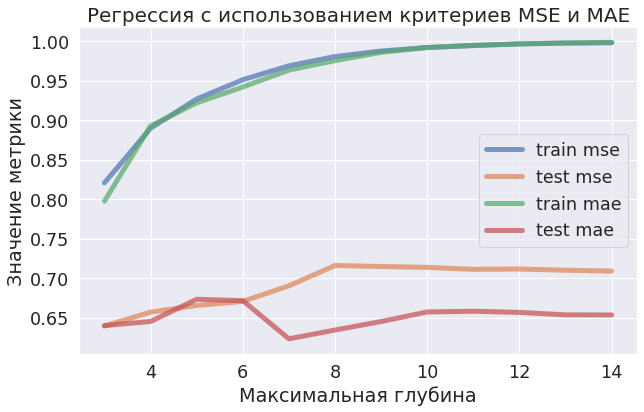

In [13]:
plot_graphs(DecisionTreeRegressor, 
            [(mean_square_criterion, 'mse'), (mean_abs_criterion, 'mae')], 
            r2_score,
            'Регрессия с использованием критериев MSE и MAE',
            max_depth_list=range(3, 15))

**Вывод.**

В данном случае оптимальные параметры для критериев разбиения различаются. Видно, что критерий, основанный на mse, даёт гораздо более высокий результат

Качество результатов, выдаваемых решающим деревом, построенным с использованием mae критерия, оказалось ниже, чем даёт дерево, использующее mse критерий. На графике видно, что при `max_depth` $> 8$ решающее дерево для квадратичной функции потерь начинает переобучаться, так как `score` на обучающей выборке растёт, а на тестовой — падает

Можно ускорить пострение решающего дерева, снизив асимптотику разбиения по признаку с $O(un)$ до $O(u+n \cdot \text{log} n)$, где $u$ &mdash; количество значений признака, а $n$ &mdash; количество различных значений

Рассмотрим пример для MSE. Преобразуем функционал MSE:
$$MSE(y_1, ..., y_n) = \frac{1}{n}\sum\limits_{1}^n (y_i - \overline{Y})^2 = \overline{Y^2} - \overline{Y}^2.$$

Можно предподсчитать на префиксах и на суффиксах суммы квадратов и квадраты сумм $y_i$ и тогда значение каждого функционала будет вычислять не за линейное, а за константное время. Но перед использованием данного алгоритма, нужно отсортировать элементы, попавшие в вершину, по разделяемому признаку